In [1]:
from os.path import join
from datetime import datetime

import numpy as np
import pandas as pd
from pymagicc.io import MAGICCData

from openscm.core import Core, ParameterSet
from openscm.utils import convert_datetime_to_openscm_time
from openscm.units import unit_registry
from openscm.internal import Adapter
from openscm.adapters import get_adapter, MAGICC6
from openscm.highlevel import OpenSCMDataFrame

<IPython.core.display.Javascript object>

In [2]:
import matplotlib
%matplotlib inline

In [3]:
DATA_PATH = join("..", "data", "rcps")
# make internal
ONE_YEAR = 1*unit_registry("yr").to("s").magnitude

In [4]:
rcp26 = MAGICCData(
    join(DATA_PATH, "RCP26_EMISSIONS.DAT"),
    model="IMAGE",
    scenario="RCP26",
)
rcp26.head()

,variable,todo,unit,region,climate_model,model,scenario,time,value
5888,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1765-07-12 00:00:00,0.000000
5889,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1766-07-12 00:00:00,0.106998
5890,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1767-07-12 00:00:00,0.133383
5891,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1768-07-12 00:00:00,0.159847
5892,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1769-07-12 00:00:00,0.186393


In [5]:
rcps = MAGICCData(rcp26.data.copy())
rcp_dict = {
    "MiniCAM": "RCP45",
    "AIM": "RCP60",
    "MESSAGE": "RCP85",
}
for model, scenario in rcp_dict.items():
    rcps.append(
        join(DATA_PATH, "{}_EMISSIONS.DAT".format(scenario)),
        model=model,
        scenario=scenario,
    )

In [6]:
rcps.scenarios()

0    RCP26
1    RCP45
2    RCP60
3    RCP85
Name: scenario, dtype: object

In [7]:
magicc = Core(
    "MAGICC6", 
    convert_datetime_to_openscm_time(datetime(1765, 1, 1, 0, 0, 0)),
    convert_datetime_to_openscm_time(datetime(2499, 12, 31, 23, 59, 59)),
)

In [8]:
# TODO: put something like this in gap between high and low level interfaces
def convert_openscm_df_to_parameter_set(openscm_df):
    # make internal
    ONE_YEAR = 1*unit_registry("yr").to("s").magnitude
    
    parameter_set = ParameterSet()
    for (variable, region), df in openscm_df.data.groupby(["variable", "region"]):
        df = df.sort_values("time")
        variable_openscm = tuple(variable.split("|"))  # TODO: remove hard coding
        region_openscm = tuple(region.split("|"))
        unit = df.unit.unique()
        assert len(unit) == 1, "emissions timeseries should all be in one unit"  # TODO: remove this restriction
        unit = unit[0]
        syr = df.time.min().year
        assert syr == 1765, "have not considered cases other than the RCPs yet"  # TODO: remove this restriction
        eyr = df.time.max().year
        assert eyr == 2500, "have not considered cases other than the RCPs yet"  # TODO: remove this restriction
        assert len(df) == 736, "have not considered cases other than the RCPs read in by pymagicc yet"  # TODO: remove this restriction
        tstep = ONE_YEAR  # having passed all above, can safely assume this [TODO: remove this assumption]

        emms_view = parameter_set.get_writable_timeseries_view(
            variable_openscm,
            region_openscm,
            unit,
            convert_datetime_to_openscm_time(datetime(syr, 1, 1, 0, 0, 0)),
            tstep
        )
        emms_view.set_series(df["value"].values)

    return parameter_set

In [9]:
m = MAGICC6(convert_openscm_df_to_parameter_set(rcp26))
m.initialize()

object of type <class 'float'> cannot be safely interpreted as an integer.


In [10]:
results = m.run()

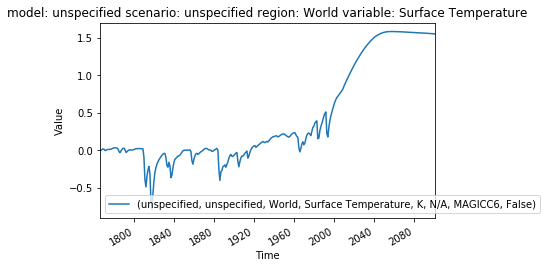

In [11]:
results.filter(
    variable="Surface Temperature",
    region="World",
).line_plot(x="time");

In [12]:
# TODO: move into highlevel
# TODO: add caching flag

# order to move to:
# - for model in models
#     - spin up model
#     - for scenario in scenarios
#        - setup scenario
#        - for config in configs
#            - run config
#            - append output to results
# - concatenate results and return
def run(drivers, model_configurations):
    assert isinstance(model_configurations, dict), "model_configurations must be a dictionary"
    for model, configurations in model_configurations.items():
        print("running {}\n".format(model))
        for i, (scenario, sdf) in enumerate(drivers.data.groupby(["scenario"])):
            print("running {}".format(scenario))
            runner = get_adapter(model)(convert_openscm_df_to_parameter_set(MAGICCData(sdf.copy())))
            runner.initialize()
#             parameter_set_scenario = 
#             runner.setup_scenario(parameter_set_scenario)
            for config in configurations:
                # temporary cheat
#                 parameter_set_config = convert_dict_to_parameter_set(config) if config is not None else None
#                 config_results = runner.run(parameter_set_config)
                config_results = runner.run(**config)
                config_results = MAGICCData(
                    config_results.data.copy(), 
                    model=sdf["model"].iloc[0], 
                    scenario=scenario, 
                )
                # temporary cheat
#                 results.append(convert_parameter_set_to_openscmdf(config_results))
                try:
                    results.append(config_results)
                except UnboundLocalError:
                    results = config_results
                # TODO: get parameters out here too
            
    return results

In [13]:
res = run(rcp26, {"MAGICC6": [{"core_climatesensitivity": 3.5}]})
res.head()

running MAGICC6

running RCP26


object of type <class 'float'> cannot be safely interpreted as an integer.


,model,scenario,region,variable,unit,time,todo,climate_model,value
3360,IMAGE,RCP26,World,Atmospheric Concentrations|CH4,ppb,1765-07-12,N/A,MAGICC6,721.89411
3361,IMAGE,RCP26,World|Northern Hemisphere|Land,Atmospheric Concentrations|CH4,ppb,1765-07-12,N/A,MAGICC6,721.89411
3362,IMAGE,RCP26,World|Northern Hemisphere|Ocean,Atmospheric Concentrations|CH4,ppb,1765-07-12,N/A,MAGICC6,721.89411
3363,IMAGE,RCP26,World|Southern Hemisphere|Land,Atmospheric Concentrations|CH4,ppb,1765-07-12,N/A,MAGICC6,721.89411
3364,IMAGE,RCP26,World|Southern Hemisphere|Ocean,Atmospheric Concentrations|CH4,ppb,1765-07-12,N/A,MAGICC6,721.89411


In [14]:
res = run(rcps, {"MAGICC6": [{"core_climatesensitivity": 3.5}]});

running MAGICC6

running RCP26


object of type <class 'float'> cannot be safely interpreted as an integer.


running RCP45


object of type <class 'float'> cannot be safely interpreted as an integer.


running RCP60


object of type <class 'float'> cannot be safely interpreted as an integer.


running RCP85


object of type <class 'float'> cannot be safely interpreted as an integer.


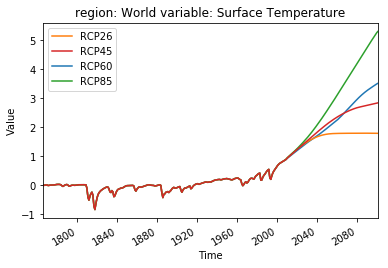

In [15]:
res.filter(variable="Surface Temperature", region="World").line_plot(color="scenario", x="time");